In [3]:
import mesa
import seaborn as sns
import numpy as np
import pandas as pd
import random

In [4]:
import matplotlib.pyplot as plt

Create Agent

Background: Agents are the individual entities that act in the model. Mesa automatically assigns each agent that is created an integer as a unique_id

In [5]:
class Cell(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        # Cell properties
        self.cell_type = cell_type="E" if random.random() < 0.5 else "M"  # "E" (epithelial) or "M" (mesenchymal)
        
    def say_hi(self):
        print(f"Hi, I am a cell, my ID is {str(self.unique_id)} and I am of type {self.cell_type}")
    
    def step(self):
        neighbors = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
        num_e_cells = sum(1 for n in neighbors if n.cell_type == "E")
        num_m_cells = sum(1 for n in neighbors if n.cell_type == "M")

        # EMT: Epithelial to Mesenchymal transition
        if self.cell_type == "E" and num_m_cells > 3:  # More than 3 mesenchymal neighbors
            self.cell_type = "M"

        # MET: Mesenchymal to Epithelial transition
        elif self.cell_type == "M" and num_e_cells > 5:  # More than 5 epithelial neighbors
            self.cell_type = "E"

        # Move if unsatisfied
        elif num_m_cells > 5 or num_e_cells < 2:  # If too surrounded by opposite type
            self.move()
    def move(self):
        # Get the adjacent cells
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        # Get the empty cells
        empty_cells = [cell for cell in neighbors if self.model.grid.is_cell_empty(cell)]
        if len(empty_cells) > 0:
            new_position = self.random.choice(empty_cells)
            self.model.grid.move_agent(self, new_position)

Create Model

Background: The model can be visualized as a list containing all the agents. The model creates, holds and manages all the agent objects, specifically in a dictionary. The model activates agents in discrete time steps.

In [ ]:
class EMTModel(mesa.Model):
    def __init__(self, num_cells, width, height, density=0.2, seed=None):
        super().__init__(seed=seed)
        self.num_cells = num_cells
        # Initialize grid
        self.grid = mesa.space.MultiGrid(width, height, torus=True) # MultiGrid allows multiple agents per cell to start, but after simulation movement allow cells to spread out and tend to one agent per cell

        # Create agents
        agents = Cell.create_agents(model=self, n=num_cells)

        # Create x and y positions for agents
        x = self.rng.integers(0, self.grid.width, size=(num_cells,))
        y = self.rng.integers(0, self.grid.height, size=(num_cells,))

        for a, i, j in zip(agents, x, y):
            # Add the agent to a random grid cell
            self.grid.place_agent(a, (i, j))

    def step(self):
        self.agents.shuffle_do("step")

In [74]:
model = EMTModel(100, 10, 10)
# for _ in range(20):
#     model.step()
model.step()

In [68]:
# from matplotlib import colormaps
# list(colormaps)

In [77]:
def count_heatmap(model):
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell_content, (x, y) in model.grid.coord_iter():
        agent_count = len(cell_content)
        agent_counts[x][y] = agent_count

    g = sns.heatmap(agent_counts, cmap="Blues", annot=True, cbar=False, square=True)
    g.figure.set_size_inches(5, 5)
    g.set(title="number of agents on each cell of the grid")
    plt.show()

def em_ratio_heatmap(model):
    # Initialize a matrix for storing E/M ratio
    cell_ratio_grid = np.zeros((model.grid.width, model.grid.height))

    # Iterate through grid and calculate E/M ratio per cell
    for cell_content, (x, y) in model.grid.coord_iter():
        num_e = sum(1 for agent in cell_content if agent.cell_type == "E")
        num_m = sum(1 for agent in cell_content if agent.cell_type == "M")
        total = num_e + num_m

        if total > 0:
            cell_ratio_grid[x, y] = num_e / total  # Ratio of E-cells (0 = all M, 1 = all E)
        else:
            cell_ratio_grid[x, y] = np.nan

    # Create a heatmap: Yellow for more E, Purple for more M
    plt.figure(figsize=(6, 6))
    g = sns.heatmap(
        cell_ratio_grid, cmap="plasma", vmin=0, vmax=1, cbar=True, square=True,
        xticklabels=False, yticklabels=False, linewidths=0.5, linecolor="black"
    )

    # Customize visualization
    g.set(title="Epithelial (Yellow) to Mesenchymal (Purple) Ratio")
    plt.show()

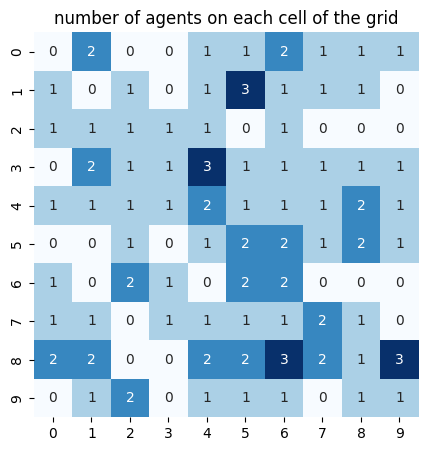

In [79]:
heatmap = count_heatmap(model)

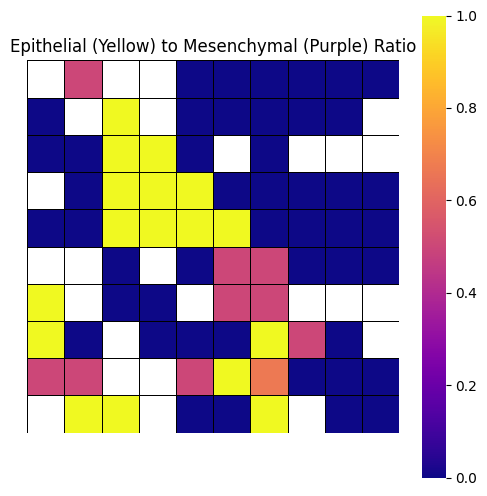

In [80]:
em_ratio_heatmap(model)

In [81]:
for _ in range(20):
    model.step()

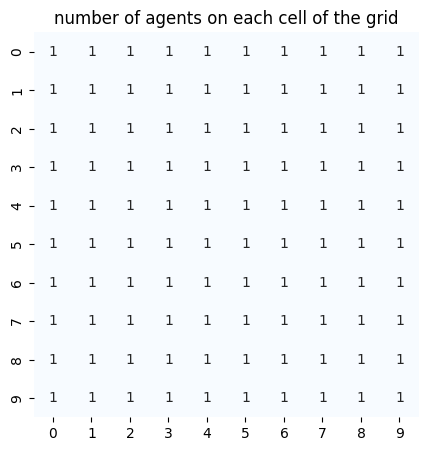

In [82]:
count_heatmap(model)

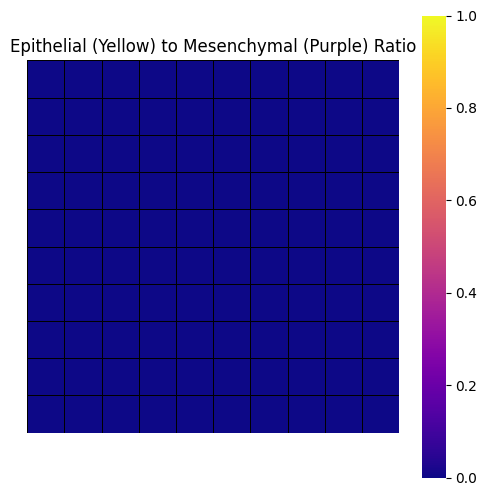

In [83]:
em_ratio_heatmap(model)